In [1]:
import json
import os
from datetime import datetime
import pickle as pkl

import geopandas as gpd
import numpy as np
import pandas as pd
import torch
import torch.utils.data as tdata
import time
import torch.nn as nn
import torch.nn.init as init

import collections.abc
import re

import torch
from torch.nn import functional as F



In [2]:
# %pip install geopandas

In [3]:
class PASTIS_Dataset(tdata.Dataset):
    def __init__(
        self,
        folder,
        norm=True,
        target="semantic",
        cache=False,
        mem16=False,
        folds=None,
        reference_date="2018-09-01",
        class_mapping=None,
        mono_date=None,
        sats=["S2"],
    ):
        """
        Pytorch Dataset class to load samples from the PASTIS dataset, for semantic and
        panoptic segmentation.

        The Dataset yields ((data, dates), target) tuples, where:
            - data contains the image time series
            - dates contains the date sequence of the observations expressed in number
              of days since a reference date
            - target is the semantic or instance target

        Args:
            folder (str): Path to the dataset
            norm (bool): If true, images are standardised using pre-computed
                channel-wise means and standard deviations.
            reference_date (str, Format : 'YYYY-MM-DD'): Defines the reference date
                based on which all observation dates are expressed. Along with the image
                time series and the target tensor, this dataloader yields the sequence
                of observation dates (in terms of number of days since the reference
                date). This sequence of dates is used for instance for the positional
                encoding in attention based approaches.
            target (str): 'semantic' or 'instance'. Defines which type of target is
                returned by the dataloader.
                * If 'semantic' the target tensor is a tensor containing the class of
                  each pixel.
                * If 'instance' the target tensor is the concatenation of several
                  signals, necessary to train the Parcel-as-Points module:
                    - the centerness heatmap,
                    - the instance ids,
                    - the voronoi partitioning of the patch with regards to the parcels'
                      centers,
                    - the (height, width) size of each parcel
                    - the semantic label of each parcel
                    - the semantic label of each pixel
            cache (bool): If True, the loaded samples stay in RAM, default False.
            mem16 (bool): Additional argument for cache. If True, the image time
                series tensors are stored in half precision in RAM for efficiency.
                They are cast back to float32 when returned by __getitem__.
            folds (list, optional): List of ints specifying which of the 5 official
                folds to load. By default (when None is specified) all folds are loaded.
            class_mapping (dict, optional): Dictionary to define a mapping between the
                default 18 class nomenclature and another class grouping, optional.
            mono_date (int or str, optional): If provided only one date of the
                available time series is loaded. If argument is an int it defines the
                position of the date that is loaded. If it is a string, it should be
                in format 'YYYY-MM-DD' and the closest available date will be selected.
            sats (list): defines the satellites to use. If you are using PASTIS-R, you have access to
                Sentinel-2 imagery and Sentinel-1 observations in Ascending and Descending orbits,
                respectively S2, S1A, and S1D.
                For example use sats=['S2', 'S1A'] for Sentinel-2 + Sentinel-1 ascending time series,
                or sats=['S2', 'S1A','S1D'] to retrieve all time series.
                If you are using PASTIS, only  S2 observations are available.
        """
        super(PASTIS_Dataset, self).__init__()
        self.folder = folder
        self.norm = norm
        self.reference_date = datetime(*map(int, reference_date.split("-")))
        self.cache = cache
        self.mem16 = mem16
        self.mono_date = None
        if mono_date is not None:
            self.mono_date = (
                datetime(*map(int, mono_date.split("-")))
                if "-" in mono_date
                else int(mono_date)
            )
        self.memory = {}
        self.memory_dates = {}
        self.class_mapping = (
            np.vectorize(lambda x: class_mapping[x])
            if class_mapping is not None
            else class_mapping
        )
        self.target = target
        self.sats = sats

        # Get metadata
        print("Reading patch metadata . . .")
        self.meta_patch = gpd.read_file(os.path.join(folder, "metadata.geojson"))
        self.meta_patch.index = self.meta_patch["ID_PATCH"].astype(int)
        self.meta_patch.sort_index(inplace=True)

        self.date_tables = {s: None for s in sats}
        self.date_range = np.array(range(-200, 600))
        for s in sats:
            dates = self.meta_patch["dates-{}".format(s)]
            date_table = pd.DataFrame(
                index=self.meta_patch.index, columns=self.date_range, dtype=int
            )
            for pid, date_seq in dates.items():
                d = pd.DataFrame().from_dict(date_seq, orient="index")
                d = d[0].apply(
                    lambda x: (
                        datetime(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:]))
                        - self.reference_date
                    ).days
                )
                date_table.loc[pid, d.values] = 1
            date_table = date_table.fillna(0)
            self.date_tables[s] = {
                index: np.array(list(d.values()))
                for index, d in date_table.to_dict(orient="index").items()
            }

        print("Done.")

        # Select Fold samples
        if folds is not None:
            self.meta_patch = pd.concat(
                [self.meta_patch[self.meta_patch["Fold"] == f] for f in folds]
            )

        self.len = self.meta_patch.shape[0]
        self.id_patches = self.meta_patch.index

        # Get normalisation values
        if norm:
            self.norm = {}
            for s in self.sats:
                with open(
                    os.path.join(folder, "NORM_{}_patch.json".format(s)), "r"
                ) as file:
                    normvals = json.loads(file.read())
                selected_folds = folds if folds is not None else range(1, 6)
                means = [normvals["Fold_{}".format(f)]["mean"] for f in selected_folds]
                stds = [normvals["Fold_{}".format(f)]["std"] for f in selected_folds]
                self.norm[s] = np.stack(means).mean(axis=0), np.stack(stds).mean(axis=0)
                self.norm[s] = (
                    torch.from_numpy(self.norm[s][0]).float(),
                    torch.from_numpy(self.norm[s][1]).float(),
                )
        else:
            self.norm = None
        print("Dataset ready.")

    def __len__(self):
        return self.len

    def get_dates(self, id_patch, sat):
        return self.date_range[np.where(self.date_tables[sat][id_patch] == 1)[0]]

    def __getitem__(self, item):
        id_patch = self.id_patches[item]

        # Retrieve and prepare satellite data
        if not self.cache or item not in self.memory.keys():
            data = {
                satellite: np.load(
                    os.path.join(
                        self.folder,
                        "DATA_{}".format(satellite),
                        "{}_{}.npy".format(satellite, id_patch),
                    )
                ).astype(np.float32)
                for satellite in self.sats
            }  # T x C x H x W arrays
            data = {s: torch.from_numpy(a) for s, a in data.items()}

            if self.norm is not None:
                data = {
                    s: (d - self.norm[s][0][None, :, None, None])
                    / self.norm[s][1][None, :, None, None]
                    for s, d in data.items()
                }

            if self.target == "semantic":
                target = np.load(
                    os.path.join(
                        self.folder, "ANNOTATIONS", "TARGET_{}.npy".format(id_patch)
                    )
                )
                target = torch.from_numpy(target[0].astype(int))

                if self.class_mapping is not None:
                    target = self.class_mapping(target)

            elif self.target == "instance":
                heatmap = np.load(
                    os.path.join(
                        self.folder,
                        "INSTANCE_ANNOTATIONS",
                        "HEATMAP_{}.npy".format(id_patch),
                    )
                )

                instance_ids = np.load(
                    os.path.join(
                        self.folder,
                        "INSTANCE_ANNOTATIONS",
                        "INSTANCES_{}.npy".format(id_patch),
                    )
                )
                pixel_to_object_mapping = np.load(
                    os.path.join(
                        self.folder,
                        "INSTANCE_ANNOTATIONS",
                        "ZONES_{}.npy".format(id_patch),
                    )
                )

                pixel_semantic_annotation = np.load(
                    os.path.join(
                        self.folder, "ANNOTATIONS", "TARGET_{}.npy".format(id_patch)
                    )
                )

                if self.class_mapping is not None:
                    pixel_semantic_annotation = self.class_mapping(
                        pixel_semantic_annotation[0]
                    )
                else:
                    pixel_semantic_annotation = pixel_semantic_annotation[0]

                size = np.zeros((*instance_ids.shape, 2))
                object_semantic_annotation = np.zeros(instance_ids.shape)
                for instance_id in np.unique(instance_ids):
                    if instance_id != 0:
                        h = (instance_ids == instance_id).any(axis=-1).sum()
                        w = (instance_ids == instance_id).any(axis=-2).sum()
                        size[pixel_to_object_mapping == instance_id] = (h, w)
                        object_semantic_annotation[
                            pixel_to_object_mapping == instance_id
                        ] = pixel_semantic_annotation[instance_ids == instance_id][0]

                target = torch.from_numpy(
                    np.concatenate(
                        [
                            heatmap[:, :, None],  # 0
                            instance_ids[:, :, None],  # 1
                            pixel_to_object_mapping[:, :, None],  # 2
                            size,  # 3-4
                            object_semantic_annotation[:, :, None],  # 5
                            pixel_semantic_annotation[:, :, None],  # 6
                        ],
                        axis=-1,
                    )
                ).float()

            if self.cache:
                if self.mem16:
                    self.memory[item] = [{k: v.half() for k, v in data.items()}, target]
                else:
                    self.memory[item] = [data, target]

        else:
            data, target = self.memory[item]
            if self.mem16:
                data = {k: v.float() for k, v in data.items()}

        # Retrieve date sequences
        if not self.cache or id_patch not in self.memory_dates.keys():
            dates = {
                s: torch.from_numpy(self.get_dates(id_patch, s)) for s in self.sats
            }
            if self.cache:
                self.memory_dates[id_patch] = dates
        else:
            dates = self.memory_dates[id_patch]

        if self.mono_date is not None:
            if isinstance(self.mono_date, int):
                data = {s: data[s][self.mono_date].unsqueeze(0) for s in self.sats}
                dates = {s: dates[s][self.mono_date] for s in self.sats}
            else:
                mono_delta = (self.mono_date - self.reference_date).days
                mono_date = {
                    s: int((dates[s] - mono_delta).abs().argmin()) for s in self.sats
                }
                data = {s: data[s][mono_date[s]].unsqueeze(0) for s in self.sats}
                dates = {s: dates[s][mono_date[s]] for s in self.sats}

        if self.mem16:
            return ({k: v.float() for k, v in data.items()}, dates), target
        else:
            return (data, dates), target

In [4]:



def pad_tensor(x, l, pad_value=0):
    padlen = l - x.shape[0]
    pad = [0 for _ in range(2 * len(x.shape[1:]))] + [0, padlen]
    return F.pad(x, pad=pad, value=pad_value)


np_str_obj_array_pattern = re.compile(r"[SaUO]")


def pad_collate(batch, pad_value=0):
    # Utility function to be used as collate_fn for the PyTorch dataloader
    # to handle sequences of varying length.
    # Sequences are padded with zeros by default.
    #
    # Modified default_collate from the official pytorch repo
    # https://github.com/pytorch/pytorch/blob/master/torch/utils/data/_utils/collate.py
    elem = batch[0]
    elem_type = type(elem)
    if isinstance(elem, torch.Tensor):
        out = None
        if len(elem.shape) > 0:
            sizes = [e.shape[0] for e in batch]
            m = max(sizes)
            if not all(s == m for s in sizes):
                # pad tensors which have a temporal dimension
                batch = [pad_tensor(e, m, pad_value=pad_value) for e in batch]
        if torch.utils.data.get_worker_info() is not None:
            # If we're in a background process, concatenate directly into a
            # shared memory tensor to avoid an extra copy
            numel = sum([x.numel() for x in batch])
            storage = elem.storage()._new_shared(numel)
            out = elem.new(storage)
        return torch.stack(batch, 0, out=out)
    elif (
        elem_type.__module__ == "numpy"
        and elem_type.__name__ != "str_"
        and elem_type.__name__ != "string_"
    ):
        if elem_type.__name__ == "ndarray" or elem_type.__name__ == "memmap":
            # array of string classes and object
            if np_str_obj_array_pattern.search(elem.dtype.str) is not None:
                raise TypeError("Format not managed : {}".format(elem.dtype))

            return pad_collate([torch.as_tensor(b) for b in batch])
        elif elem.shape == ():  # scalars
            return torch.as_tensor(batch)

    elif isinstance(elem, collections.abc.Mapping):
        return {key: pad_collate([d[key] for d in batch]) for key in elem}

    elif isinstance(elem, tuple) and hasattr(elem, "_fields"):  # namedtuple
        return elem_type(*(pad_collate(samples) for samples in zip(*batch)))

    elif isinstance(elem, collections.abc.Sequence):
        # check to make sure that the elements in batch have consistent size
        it = iter(batch)
        elem_size = len(next(it))
        if not all(len(elem) == elem_size for elem in it):
            raise RuntimeError("each element in list of batch should be of equal size")
        transposed = zip(*batch)
        return [pad_collate(samples) for samples in transposed]

    raise TypeError("Format not managed : {}".format(elem_type))
    
def get_ntrainparams(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [5]:
# fold_sequence = [
#         [[1, 2, 3], [4], [5]],
#         [[2, 3, 4], [5], [1]],
#         [[3, 4, 5], [1], [2]],
#         [[4, 5, 1], [2], [3]],
#         [[5, 1, 2], [3], [4]],
#     ]
# for fold, (train_folds, val_fold, test_fold) in enumerate(fold_sequence):
#     print((train_folds, val_fold, test_fold))

### Model definition

In [6]:
import torch
import torch.nn as nn


def conv_block(in_dim, middle_dim, out_dim):
    model = nn.Sequential(
        nn.Conv3d(in_dim, middle_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm3d(middle_dim),
        nn.LeakyReLU(inplace=True),
        nn.Conv3d(middle_dim, out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm3d(out_dim),
        nn.LeakyReLU(inplace=True),
    )
    return model


def center_in(in_dim, out_dim):
    model = nn.Sequential(
        nn.Conv3d(in_dim, out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm3d(out_dim),
        nn.LeakyReLU(inplace=True))
    return model


def center_out(in_dim, out_dim):
    model = nn.Sequential(
        nn.Conv3d(in_dim, in_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm3d(in_dim),
        nn.LeakyReLU(inplace=True),
        nn.ConvTranspose3d(in_dim, out_dim, kernel_size=3, stride=2, padding=1, output_padding=1))
    return model


def up_conv_block(in_dim, out_dim):
    model = nn.Sequential(
        nn.ConvTranspose3d(in_dim, out_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm3d(out_dim),
        nn.LeakyReLU(inplace=True),
    )
    return model


class UNet3D(nn.Module):
    def __init__(self, in_channel, n_classes, feats=8, pad_value=None, zero_pad=True):
        super(UNet3D, self).__init__()
        self.in_channel = in_channel
        self.n_classes = n_classes
        self.pad_value = pad_value
        self.zero_pad = zero_pad

        self.en3 = conv_block(in_channel, feats * 4, feats * 4)
        self.pool_3 = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
        self.en4 = conv_block(feats * 4, feats * 8, feats * 8)
        self.pool_4 = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
        self.center_in = center_in(feats * 8, feats * 16)
        self.center_out = center_out(feats * 16, feats * 8)
        self.dc4 = conv_block(feats * 16, feats * 8, feats * 8)
        self.trans3 = up_conv_block(feats * 8, feats * 4)
        self.dc3 = conv_block(feats * 8, feats * 4, feats * 2)
        self.final = nn.Conv3d(feats * 2, n_classes, kernel_size=3, stride=1, padding=1)
        # self.fn = nn.Linear(timesteps, 1)
        # self.logsoftmax = nn.LogSoftmax(dim=1)
        # self.dropout = nn.Dropout(p=dropout, inplace=True)

    def forward(self, x, batch_positions=None):
        out = x.permute(0, 2, 1, 3, 4)
        if self.pad_value is not None:
            pad_mask = (out == self.pad_value).all(dim=-1).all(dim=-1).all(dim=1)  # BxT pad mask
            if self.zero_pad:
                out[out == self.pad_value] = 0
        en3 = self.en3(out)
        pool_3 = self.pool_3(en3)
        en4 = self.en4(pool_3)
        pool_4 = self.pool_4(en4)
        center_in = self.center_in(pool_4)
        center_out = self.center_out(center_in)
        concat4 = torch.cat([center_out, en4[:, :, :center_out.shape[2], :, :]], dim=1)
        dc4 = self.dc4(concat4)
        trans3 = self.trans3(dc4)
        concat3 = torch.cat([trans3, en3[:, :, :trans3.shape[2], :, :]], dim=1)
        dc3 = self.dc3(concat3)
        final = self.final(dc3)
        final = final.permute(0, 1, 3, 4, 2)  # BxCxHxWxT

        # shape_num = final.shape[0:4]
        # final = final.reshape(-1,final.shape[4])
        if self.pad_value is not None:
            if pad_mask.any():
                # masked mean
                pad_mask = pad_mask[:, :final.shape[-1]] #match new temporal length (due to pooling)
                pad_mask = ~pad_mask # 0 on padded values
                out = (final.permute(1, 2, 3, 0, 4) * pad_mask[None, None, None, :, :]).sum(dim=-1) / pad_mask.sum(
                    dim=-1)[None, None, None, :]
                out = out.permute(3, 0, 1, 2)
            else:
                out = final.mean(dim=-1)
        else:
            out = final.mean(dim=-1)
        # final = self.dropout(final)
        # final = self.fn(final)
        # final = final.reshape(shape_num)

        return out

### METRICS

In [7]:
class Metric(object):
    """Base class for all metrics.
    From: https://github.com/pytorch/tnt/blob/master/torchnet/meter/meter.py
    """

    def reset(self):
        pass

    def add(self):
        pass

    def value(self):
        pass


class ConfusionMatrix(Metric):
    """Constructs a confusion matrix for a multi-class classification problems.

    Does not support multi-label, multi-class problems.

    Keyword arguments:
    - num_classes (int): number of classes in the classification problem.
    - normalized (boolean, optional): Determines whether or not the confusion
    matrix is normalized or not. Default: False.

    Modified from: https://github.com/pytorch/tnt/blob/master/torchnet/meter/confusionmeter.py
    """

    def __init__(self, num_classes, normalized=False, device='cpu', lazy=True):
        super().__init__()
        if device == 'cpu':
            self.conf = np.ndarray((num_classes, num_classes), dtype=np.int64)
        else:
            self.conf = torch.zeros((num_classes, num_classes)).cuda()
        self.normalized = normalized
        self.num_classes = num_classes
        self.device = device
        self.reset()
        self.lazy = lazy

    def reset(self):
        if self.device == 'cpu':
            self.conf.fill(0)
        else:
            self.conf = torch.zeros(self.conf.shape).cuda()

    def add(self, predicted, target):
        """Computes the confusion matrix

        The shape of the confusion matrix is K x K, where K is the number
        of classes.

        Keyword arguments:
        - predicted (Tensor or numpy.ndarray): Can be an N x K tensor/array of
        predicted scores obtained from the model for N examples and K classes,
        or an N-tensor/array of integer values between 0 and K-1.
        - target (Tensor or numpy.ndarray): Can be an N x K tensor/array of
        ground-truth classes for N examples and K classes, or an N-tensor/array
        of integer values between 0 and K-1.

        """

        # If target and/or predicted are tensors, convert them to numpy arrays
        if self.device == 'cpu':
            if torch.is_tensor(predicted):
                predicted = predicted.cpu().numpy()
            if torch.is_tensor(target):
                target = target.cpu().numpy()

        assert predicted.shape[0] == target.shape[0], \
            'number of targets and predicted outputs do not match'

        if len(predicted.shape) != 1:
            assert predicted.shape[1] == self.num_classes, \
                'number of predictions does not match size of confusion matrix'
            predicted = predicted.argmax(1)
        else:
            if not self.lazy:
                assert (predicted.max() < self.num_classes) and (predicted.min() >= 0), \
                    'predicted values are not between 0 and k-1'

        if len(target.shape) != 1:
            if not self.lazy:
                assert target.shape[1] == self.num_classes, \
                    'Onehot target does not match size of confusion matrix'
                assert (target >= 0).all() and (target <= 1).all(), \
                    'in one-hot encoding, target values should be 0 or 1'
                assert (target.sum(1) == 1).all(), \
                    'multi-label setting is not supported'
            target = target.argmax(1)
        else:
            if not self.lazy:
                assert (target.max() < self.num_classes) and (target.min() >= 0), \
                    'target values are not between 0 and k-1'

        # hack for bincounting 2 arrays together
        x = predicted + self.num_classes * target

        if self.device == 'cpu':
            bincount_2d = np.bincount(
                x.astype(np.int64), minlength=self.num_classes ** 2)
            assert bincount_2d.size == self.num_classes ** 2
            conf = bincount_2d.reshape((self.num_classes, self.num_classes))
        else:
            bincount_2d = torch.bincount(
                x, minlength=self.num_classes ** 2)

            conf = bincount_2d.view((self.num_classes, self.num_classes))
        self.conf += conf

    def value(self):
        """
        Returns:
            Confustion matrix of K rows and K columns, where rows corresponds
            to ground-truth targets and columns corresponds to predicted
            targets.
        """
        if self.normalized:
            conf = self.conf.astype(np.float32)
            return conf / conf.sum(1).clip(min=1e-12)[:, None]
        else:
            return self.conf


class IoU(Metric):
    """Computes the intersection over union (IoU) per class and corresponding
    mean (mIoU).

    Intersection over union (IoU) is a common evaluation metric for semantic
    segmentation. The predictions are first accumulated in a confusion matrix
    and the IoU is computed from it as follows:

        IoU = true_positive / (true_positive + false_positive + false_negative).

    Keyword arguments:
    - num_classes (int): number of classes in the classification problem
    - normalized (boolean, optional): Determines whether or not the confusion
    matrix is normalized or not. Default: False.
    - ignore_index (int or iterable, optional): Index of the classes to ignore
    when computing the IoU. Can be an int, or any iterable of ints.
    """

    def __init__(self, num_classes, normalized=False, ignore_index=None, cm_device='cpu', lazy=True):
        super().__init__()
        self.conf_metric = ConfusionMatrix(num_classes, normalized, device=cm_device, lazy=lazy)
        self.lazy = lazy
        if ignore_index is None:
            self.ignore_index = None
        elif isinstance(ignore_index, int):
            self.ignore_index = (ignore_index,)
        else:
            try:
                self.ignore_index = tuple(ignore_index)
            except TypeError:
                raise ValueError("'ignore_index' must be an int or iterable")

    def reset(self):
        self.conf_metric.reset()

    def add(self, predicted, target):
        """Adds the predicted and target pair to the IoU metric.

        Keyword arguments:
        - predicted (Tensor): Can be a (N, K, H, W) tensor of
        predicted scores obtained from the model for N examples and K classes,
        or (N, H, W) tensor of integer values between 0 and K-1.
        - target (Tensor): Can be a (N, K, H, W) tensor of
        target scores for N examples and K classes, or (N, H, W) tensor of
        integer values between 0 and K-1.

        """
        # Dimensions check
        assert predicted.size(0) == target.size(0), \
            'number of targets and predicted outputs do not match'
        assert predicted.dim() == 3 or predicted.dim() == 4, \
            "predictions must be of dimension (N, H, W) or (N, K, H, W)"
        assert target.dim() == 3 or target.dim() == 4, \
            "targets must be of dimension (N, H, W) or (N, K, H, W)"

        # If the tensor is in categorical format convert it to integer format
        if predicted.dim() == 4:
            _, predicted = predicted.max(1)
        if target.dim() == 4:
            _, target = target.max(1)

        self.conf_metric.add(predicted.view(-1), target.view(-1))

    def value(self):
        """Computes the IoU and mean IoU.

        The mean computation ignores NaN elements of the IoU array.

        Returns:
            Tuple: (IoU, mIoU). The first output is the per class IoU,
            for K classes it's numpy.ndarray with K elements. The second output,
            is the mean IoU.
        """
        conf_matrix = self.conf_metric.value()
        if self.ignore_index is not None:
            conf_matrix[:, self.ignore_index] = 0
            conf_matrix[self.ignore_index, :] = 0
        true_positive = np.diag(conf_matrix)
        false_positive = np.sum(conf_matrix, 0) - true_positive
        false_negative = np.sum(conf_matrix, 1) - true_positive

        # Just in case we get a division by 0, ignore/hide the error
        with np.errstate(divide='ignore', invalid='ignore'):
            iou = true_positive / (true_positive + false_positive + false_negative)

        return iou, np.nanmean(iou)

    def get_miou_acc(self):
        conf_matrix = self.conf_metric.value()
        if torch.is_tensor(conf_matrix):
            conf_matrix = conf_matrix.cpu().numpy()
        if self.ignore_index is not None:
            conf_matrix[:, self.ignore_index] = 0
            conf_matrix[self.ignore_index, :] = 0
        true_positive = np.diag(conf_matrix)
        false_positive = np.sum(conf_matrix, 0) - true_positive
        false_negative = np.sum(conf_matrix, 1) - true_positive

        # Just in case we get a division by 0, ignore/hide the error
        with np.errstate(divide='ignore', invalid='ignore'):
            iou = true_positive / (true_positive + false_positive + false_negative)
        miou = float(np.nanmean(iou) * 100)
        acc = float(np.diag(conf_matrix).sum() / conf_matrix.sum() * 100)

        return miou, acc

In [8]:
def confusion_matrix_analysis(mat):
    """
    This method computes all the performance metrics from the confusion matrix. In addition to overall accuracy, the
    precision, recall, f-score and IoU for each class is computed.
    The class-wise metrics are averaged to provide overall indicators in two ways (MICRO and MACRO average)
    Args:
        mat (array): confusion matrix

    Returns:
        per_class (dict) : per class metrics
        overall (dict): overall metrics

    """
    TP = 0
    FP = 0
    FN = 0

    per_class = {}

    for j in range(mat.shape[0]):
        d = {}
        tp = np.sum(mat[j, j])
        fp = np.sum(mat[:, j]) - tp
        fn = np.sum(mat[j, :]) - tp

        d['IoU'] = tp / (tp + fp + fn)
        d['Precision'] = tp / (tp + fp)
        d['Recall'] = tp / (tp + fn)
        d['F1-score'] = 2 * tp / (2 * tp + fp + fn)

        per_class[str(j)] = d

        TP += tp
        FP += fp
        FN += fn

    overall = {}
    overall['micro_IoU'] = TP / (TP + FP + FN)
    overall['micro_Precision'] = TP / (TP + FP)
    overall['micro_Recall'] = TP / (TP + FN)
    overall['micro_F1-score'] = 2 * TP / (2 * TP + FP + FN)

    macro = pd.DataFrame(per_class).transpose().mean()
    overall['MACRO_IoU'] = macro.loc['IoU']
    overall['MACRO_Precision'] = macro.loc['Precision']
    overall['MACRO_Recall'] = macro.loc['Recall']
    overall['MACRO_F1-score'] = macro.loc['F1-score']

    overall['Accuracy'] = np.sum(np.diag(mat)) / np.sum(mat)

    return per_class, overall

In [9]:
def iterate(
    model, data_loader, criterion, optimizer=None, mode="train", device=None
):
    iou_meter = IoU(
        num_classes=NUM_CLASSES,
        ignore_index=IGNORE_INDEX,
        cm_device=DEVICE,
    )

    t_start = time.time()
    for i, batch in enumerate(data_loader):
        if device is not None:
            batch = recursive_todevice(batch, DEVICE)
        (x, dates), y = batch
        (x, dates) = x['S2'], dates['S2']
        y = y.long()

        if mode != "train":
            with torch.no_grad():
                out = model(x, batch_positions=dates)
        else:
            optimizer.zero_grad()
            out = model(x, batch_positions=dates)

        loss = criterion(out, y)
        if mode == "train":
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            pred = out.argmax(dim=1)
        iou_meter.add(pred, y)
#         loss_meter.add(loss.item())

        if (i + 1) % DISPLAY_SETUP == 0:
            miou, acc = iou_meter.get_miou_acc()
            print(
                "Step [{}/{}], Loss: {:.4f}, Acc : {:.2f}, mIoU {:.2f}".format(
                    i + 1, len(data_loader), loss.item(), acc, miou
                )
            )

    t_end = time.time()
    total_time = t_end - t_start
    print("Epoch time : {:.1f}s".format(total_time))
    miou, acc = iou_meter.get_miou_acc()
    metrics = {
        "{}_accuracy".format(mode): acc,
        "{}_loss".format(mode): loss.item(),
        "{}_IoU".format(mode): miou,
        "{}_epoch_time".format(mode): total_time,
    }

    if mode == "test":
        return metrics, iou_meter.conf_metric.value()  # confusion matrix
    else:
        return metrics


def recursive_todevice(x, device):
    if isinstance(x, torch.Tensor):
        return x.to(device)
    elif isinstance(x, dict):
        return {k: recursive_todevice(v, device) for k, v in x.items()}
    else:
        return [recursive_todevice(c, device) for c in x]

In [10]:


def weight_init(m):
    '''
    Initializes a model's parameters.
    Credits to: https://gist.github.com/jeasinema

    Usage:
        model = Model()
        model.apply(weight_init)
    '''
    if isinstance(m, nn.Conv1d):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv3d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose1d):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose3d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.BatchNorm1d):
        init.normal_(m.weight.data, mean=0, std=1)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        init.normal_(m.weight.data, mean=0, std=1)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm3d):
        init.normal_(m.weight.data, mean=0, std=1)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight.data)
        try:
            init.normal_(m.bias.data)
        except AttributeError:
            pass
    elif isinstance(m, nn.LSTM):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.LSTMCell):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.GRU):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.GRUCell):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
                
                
def save_results(fold, metrics, conf_mat):
    with open(
        os.path.join(RES_DIR,f"Fold_{fold}_test_metrics.json"), "w" 
    ) as outfile:
        json.dump(metrics, outfile, indent=4)
    pkl.dump(
        conf_mat,
        open(
            os.path.join(RES_DIR, f"Fold_{fold}_conf_mat.pkl"), "wb"
        ),
    )

In [11]:
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
LEARNING_RATE = 0.001
NUM_CLASSES = 20
IGNORE_INDEX = -1
EPOCHS=100
PAD_VALUE = 0
DISPLAY_SETUP = 50
BATCH_SIZE=4
VAL_EVERY = 1
VAL_AFTER=0
RES_DIR = 'models'
if not os.path.exists(RES_DIR):
    os.makedirs(RES_DIR)

fold_sequence = [
        [[1, 2, 3], [4], [5]],
        [[2, 3, 4], [5], [1]],
        [[3, 4, 5], [1], [2]],
        [[4, 5, 1], [2], [3]],
        [[5, 1, 2], [3], [4]],
    ]

PASTIS_PATH = 'archive/PASTIS'

for fold, (train_folds, val_fold, test_fold) in enumerate(fold_sequence):
    
    train_dataset =  PASTIS_Dataset(PASTIS_PATH, folds = train_folds )
    vali_dataset =  PASTIS_Dataset(PASTIS_PATH, folds = val_fold )
    test_dataset =  PASTIS_Dataset(PASTIS_PATH, folds = test_fold )


    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=pad_collate, drop_last=True,shuffle=True)
    vali_dataloader = torch.utils.data.DataLoader(vali_dataset, batch_size=BATCH_SIZE, collate_fn=pad_collate, drop_last=True,shuffle=True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=pad_collate, drop_last=True,shuffle=True)
    
    print(
            "Train {}, Val {}, Test {}".format(len(train_dataloader), len(vali_dataloader), len(test_dataloader))
        )
    
    
    model = UNet3D(
                    in_channel=10, n_classes=NUM_CLASSES, pad_value=PAD_VALUE
                )
    N_PARAMS = get_ntrainparams(model)
    print(f"Model has {N_PARAMS} trainable params")
    print(model)
    model = model.to(DEVICE)
    model.apply(weight_init)

    # Optimizer and Loss
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    weights = torch.ones(NUM_CLASSES, device=DEVICE).float()
    weights[IGNORE_INDEX] = 0
    criterion = nn.CrossEntropyLoss(weight=weights)
    TRAIN_LOG = {}
    best_mIoU = 0
    for epoch in range(1, EPOCHS + 1):
        print("EPOCH {}/{}".format(epoch, EPOCHS))

        model.train()
        train_metrics = iterate(
            model,
            data_loader=train_dataloader,
            criterion=criterion,
            optimizer=optimizer,
            mode="train",
            device=DEVICE,
        )
        if epoch % VAL_EVERY == 0 and epoch > VAL_AFTER:
            print("Validation . . . ")
            model.eval()
            val_metrics = iterate(
                model,
                data_loader=vali_dataloader,
                criterion=criterion,
                optimizer=optimizer,
                mode="val",
                device=DEVICE,
            )

            print(
                "Loss {:.4f},  Acc {:.2f},  IoU {:.4f}".format(
                    val_metrics["val_loss"],
                    val_metrics["val_accuracy"],
                    val_metrics["val_IoU"],
                )
            )
            TRAIN_LOG[epoch] = {**train_metrics, **val_metrics}
            if val_metrics["val_IoU"] >= best_mIoU:
                best_mIoU = val_metrics["val_IoU"]
                torch.save(
                    {
                        "epoch": epoch,
                        "state_dict": model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                    },
                    os.path.join(
                        RES_DIR, f"Fold_{fold+1}_model.pth.tar"
                    ),
                )
        else:
            TRAIN_LOG[epoch] = {**train_metrics}
        
        
    print("Testing best epoch . . .")
    model.load_state_dict(
        torch.load(
            os.path.join(
                RES_DIR, f"Fold_{fold+1}_model.pth.tar"
            )
        )["state_dict"]
    )
    model.eval()

    test_metrics, conf_mat = iterate(
        model,
        data_loader=test_dataloader,
        criterion=criterion,
        optimizer=optimizer,
        mode="test",
        device=DEVICE,
    )
    print(
        "Loss {:.4f},  Acc {:.2f},  IoU {:.4f}".format(
            test_metrics["test_loss"],
            test_metrics["test_accuracy"],
            test_metrics["test_IoU"],
        )
    )
    save_results(fold + 1, test_metrics, conf_mat.cpu().numpy())
    with open(f'Fold_{fold}_trainlogs.json', 'w') as file:
     file.write(json.dumps(TRAIN_LOG)) 
            

Reading patch metadata . . .
Done.
Dataset ready.
Reading patch metadata . . .
Done.
Dataset ready.
Reading patch metadata . . .
Done.
Dataset ready.
Train 363, Val 120, Test 124
Model has 1553796 trainable params
UNet3D(
  (en3): Sequential(
    (0): Conv3d(10, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (pool_3): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (en4): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU

Testing best epoch . . .
torch.Size([4, 61, 10, 128, 128])
torch.Size([4, 128, 128])
torch.Size([4, 128, 128])


/tmp/ipykernel_294405/1452866350.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = matplotlib.cm.get_cmap('tab20')


Text(0.5, 1.0, 'UNET-3D prediction')

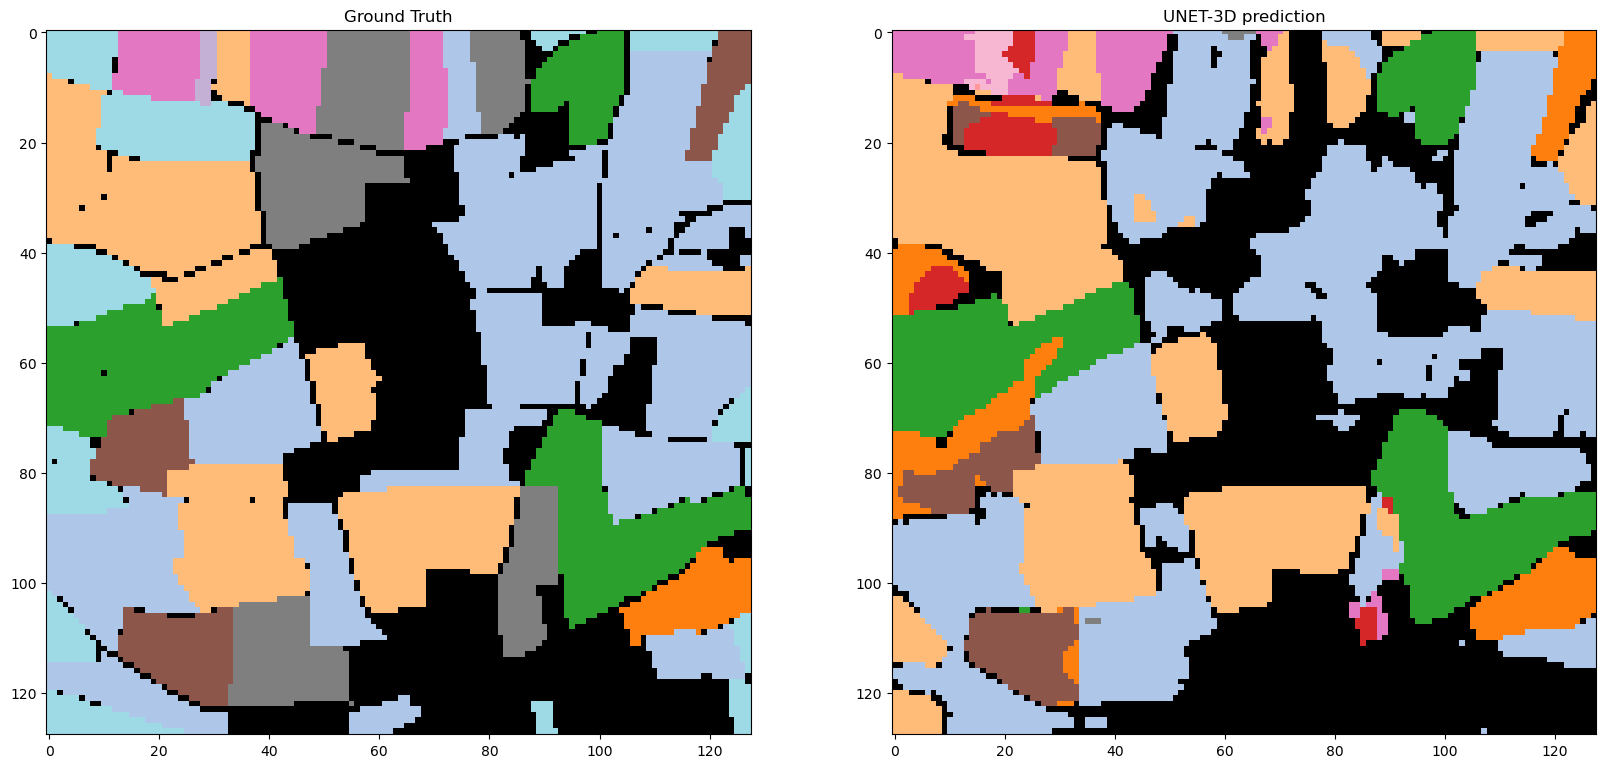

In [40]:
# TRAIN_LOG
fold = 0
print("Testing best epoch . . .")
model.load_state_dict(
    torch.load(
        os.path.join(
            RES_DIR, f"Fold_{fold+1}_model.pth.tar"
        )
    )["state_dict"]
)
model.eval()

for i, batch in enumerate(test_dataloader):
    if i==0:
        if DEVICE is not None:
            batch = recursive_todevice(batch, DEVICE)
        (x, dates), y = batch
        (x, dates) = x['S2'], dates['S2']
        y = y.long()
        print(x.shape)
        print(y.shape)

        with torch.no_grad():
            out = model(x, batch_positions=dates)


        loss = criterion(out, y)


        with torch.no_grad():
            pred = out.argmax(dim=1)
            print(pred.shape)
    else:
        break

import torchvision.transforms as T
from PIL import Image
import cv2

# print(pred[1].shape)
label1 = y[1].cpu().numpy()
tensor1 = pred[1].cpu().numpy()
# cv2.imwrite("tensor1.png",tensor1)
# cv2.imwrite("label1.png",label1)

import matplotlib.pyplot as plt 
import matplotlib
from matplotlib.colors import ListedColormap

cm = matplotlib.cm.get_cmap('tab20')
def_colors = cm.colors
cus_colors = ['k']+[def_colors[i] for i in range(1,20)]+['w']
cmap = ListedColormap(colors= cus_colors, name='agri', N=21)

fix, axes = plt.subplots(1,2, figsize=(20,20))
axes[0].imshow(label1,cmap=cmap, vmin=0, vmax=20 )
axes[1].imshow(tensor1,cmap=cmap, vmin=0, vmax=20 )

axes[0].set_title('Ground Truth')
axes[1].set_title('UNET-3D prediction')

# label1 = label1.unsqueeze(0).cpu().numpy().astype(np.uint8).transpose(1,2,0)
# print(label1.shape)
# img_transform = T.ToPILImage()
# label1 = img_transform(label1)
# output = img_transform(tensor1)
# label1.show()
# img = Image.fromarray((255*label1[0]).cpu().numpy().astype(np.uint8).transpose(1,2,0))
# img.show()
# output.show()




# test_metrics, conf_mat = iterate(
#     model,
#     data_loader=test_dataloader,
#     criterion=criterion,
#     optimizer=optimizer,
#     mode="test",
#     device=DEVICE,
# )
# print(
#     "Loss {:.4f},  Acc {:.2f},  IoU {:.4f}".format(
#         test_metrics["test_loss"],
#         test_metrics["test_accuracy"],
#         test_metrics["test_IoU"],
#     )
# )


In [13]:
# !zip -r unet_allresults.zip /kaggle/working